# Imports

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

# Custom Layers & Loss

In [33]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [ ]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32) 
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce = -y_true * K.log(y_pred)
        loss = self.alpha * K.pow(1.0 - y_pred, self.gamma) * ce
        return K.mean(loss, axis=-1)


In [35]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) 
        ait = K.dot(uit, self.u)                            
        ait = K.squeeze(ait, -1)                            
        a = K.softmax(ait)                                  
        a = K.expand_dims(a, -1)                            
        return K.sum(x * a, axis=1)                         


In [36]:
def jitter(x, sigma=0.03): return x + np.random.normal(0., sigma, x.shape)

# Load & Preprocess Data

In [37]:
can_data = pd.read_csv(r"G:\road\signal_extractions\attacks\correlated_signal_attack_1_masquerade.csv")
can_data.fillna(0, inplace=True)

signal_columns = [col for col in can_data.columns if "Signal" in col]
can_data['Time'] = pd.to_datetime(can_data['Time'], unit='s')
can_data = can_data.sort_values('Time').set_index('Time')
can_data[signal_columns] = can_data[signal_columns].apply(pd.to_numeric, errors='coerce')
can_data = can_data.resample('100us').mean().interpolate(method='cubic').reset_index()


#  Sliding Window Creation

In [38]:
def create_time_series(data, window_size, step_size):
    sequences, labels = [], []
    for i in range(0, len(data) - window_size, step_size):
        window = data.iloc[i:i + window_size]
        sequences.append(window[signal_columns].values)
        labels.append(1 if (window['Label'].sum() > 0) else 0)
    return np.array(sequences), np.array(labels)

In [39]:
sampling_rate = 10000
window_size = 10
step_size = 1
X, y = create_time_series(can_data, window_size, step_size)

# SPLIT + SCALING

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [41]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


Oversampling minority

In [42]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
train_df['label'] = y_train
majority = train_df[train_df['label'] == 0]
minority = train_df[train_df['label'] == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
balanced = pd.concat([majority, minority_upsampled])
X_train = balanced.drop('label', axis=1).values.reshape(-1, X_train.shape[1], X_train.shape[2])
y_train = balanced['label'].values

# Models

In [43]:
def build_model(attention=False):
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=attention)(x)
    if attention:
        x = AttentionLayer()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

# Training

In [46]:
EPOCHS = 20
BATCH_SIZE = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_standard = build_model(attention=False)
model_standard.compile(optimizer=tf.keras.optimizers.Adam(0.001, clipnorm=1.0),
                       loss='binary_crossentropy',
                       metrics=['accuracy', Precision(), Recall(), F1Score()])
model_standard.fit(X_train, y_train, validation_data=(X_test, y_test),
                   epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20
5162/5162 - 85s - loss: 0.6913 - accuracy: 0.5159 - precision_8: 0.5176 - recall_8: 0.4662 - f1_score: 0.4906 - val_loss: 0.6855 - val_accuracy: 0.6312 - val_precision_8: 0.9206 - val_recall_8: 0.0214 - val_f1_score: 0.0418 - 85s/epoch - 16ms/step
Epoch 2/20
5162/5162 - 77s - loss: 0.6865 - accuracy: 0.5340 - precision_8: 0.5477 - recall_8: 0.3903 - f1_score: 0.4558 - val_loss: 0.6781 - val_accuracy: 0.6243 - val_precision_8: 0.8571 - val_recall_8: 0.0014 - val_f1_score: 0.0029 - 77s/epoch - 15ms/step
Epoch 3/20
5162/5162 - 71s - loss: 0.6775 - accuracy: 0.5516 - precision_8: 0.6023 - recall_8: 0.3039 - f1_score: 0.4040 - val_loss: 0.6810 - val_accuracy: 0.6242 - val_precision_8: 0.8750 - val_recall_8: 8.4341e-04 - val_f1_score: 0.0017 - 71s/epoch - 14ms/step
Epoch 4/20
5162/5162 - 71s - loss: 0.6627 - accuracy: 0.5841 - precision_8: 0.6599 - recall_8: 0.3473 - f1_score: 0.4551 - val_loss: 0.6594 - val_accuracy: 0.6244 - val_precision_8: 0.8333 - val_recall_8: 0.0016 - val_f

# Model with Focal Loss

In [50]:
model_focal = build_model(attention=False)
model_focal.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy', Precision(), Recall(), F1Score()])
model_focal.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS,
                batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)


Epoch 1/20
5162/5162 - 78s - loss: 3.0795e-05 - accuracy: 0.5000 - precision_14: 0.5000 - recall_14: 1.0000 - f1_score: 0.6667 - val_loss: 4.0690e-13 - val_accuracy: 0.3761 - val_precision_14: 0.3761 - val_recall_14: 1.0000 - val_f1_score: 0.5466 - 78s/epoch - 15ms/step
Epoch 2/20
5162/5162 - 80s - loss: 9.5846e-09 - accuracy: 0.5000 - precision_14: 0.5000 - recall_14: 1.0000 - f1_score: 0.6667 - val_loss: 5.5257e-16 - val_accuracy: 0.3761 - val_precision_14: 0.3761 - val_recall_14: 1.0000 - val_f1_score: 0.5466 - 80s/epoch - 16ms/step
Epoch 3/20
5162/5162 - 90s - loss: 1.8632e-09 - accuracy: 0.5000 - precision_14: 0.5000 - recall_14: 1.0000 - f1_score: 0.6667 - val_loss: 6.5273e-19 - val_accuracy: 0.3761 - val_precision_14: 0.3761 - val_recall_14: 1.0000 - val_f1_score: 0.5466 - 90s/epoch - 17ms/step
Epoch 4/20
5162/5162 - 91s - loss: 2.8157e-09 - accuracy: 0.5000 - precision_14: 0.5000 - recall_14: 1.0000 - f1_score: 0.6667 - val_loss: 1.0196e-20 - val_accuracy: 0.3761 - val_precisio

# Attention Model

In [51]:
model_attention = build_model(attention=True)
model_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_attention.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20
5162/5162 - 104s - loss: 0.6932 - accuracy: 0.4972 - precision_16: 0.4974 - recall_16: 0.5359 - f1_score: 0.5159 - val_loss: 0.6926 - val_accuracy: 0.6239 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.0000e+00 - 104s/epoch - 20ms/step
Epoch 2/20
5162/5162 - 104s - loss: 0.6932 - accuracy: 0.4989 - precision_16: 0.4989 - recall_16: 0.4683 - f1_score: 0.4831 - val_loss: 0.6931 - val_accuracy: 0.6239 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.0000e+00 - 104s/epoch - 20ms/step
Epoch 3/20
5162/5162 - 103s - loss: 0.6932 - accuracy: 0.5009 - precision_16: 0.5011 - recall_16: 0.4290 - f1_score: 0.4622 - val_loss: 0.6955 - val_accuracy: 0.3761 - val_precision_16: 0.3761 - val_recall_16: 1.0000 - val_f1_score: 0.5466 - 103s/epoch - 20ms/step
Epoch 4/20
5162/5162 - 102s - loss: 0.6932 - accuracy: 0.4983 - precision_16: 0.4983 - recall_16: 0.5160 - f1_score: 0.5070 - val_loss: 0.6933 - val_accuracy: 0.3761 - val_precision

# Data augmentation

In [52]:
attack_idx = np.where(y_train == 1)[0]
X_augmented = np.array([jitter(sample) for sample in X_train[attack_idx]])
y_augmented = np.ones(len(X_augmented))
X_train_aug = np.concatenate([X_train, X_augmented])
y_train_aug = np.concatenate([y_train, y_augmented])

In [53]:
model_aug = build_model(attention=False)
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_aug.fit(X_train_aug, y_train_aug, validation_data=(X_test, y_test), epochs=EPOCHS,
              batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20
7742/7742 - 150s - loss: 0.4707 - accuracy: 0.6935 - precision_18: 0.8337 - recall_18: 0.6748 - f1_score: 0.7459 - val_loss: 0.6789 - val_accuracy: 0.6479 - val_precision_18: 0.9307 - val_recall_18: 0.0691 - val_f1_score: 0.1286 - 150s/epoch - 19ms/step
Epoch 2/20
7742/7742 - 125s - loss: 0.4540 - accuracy: 0.6944 - precision_18: 0.8897 - recall_18: 0.6182 - f1_score: 0.7295 - val_loss: 0.6776 - val_accuracy: 0.6733 - val_precision_18: 0.9502 - val_recall_18: 0.1387 - val_f1_score: 0.2421 - 125s/epoch - 16ms/step
Epoch 3/20
7742/7742 - 109s - loss: 0.4417 - accuracy: 0.7175 - precision_18: 0.8786 - recall_18: 0.6687 - f1_score: 0.7594 - val_loss: 0.6190 - val_accuracy: 0.7022 - val_precision_18: 0.7596 - val_recall_18: 0.3048 - val_f1_score: 0.4350 - 109s/epoch - 14ms/step
Epoch 4/20
7742/7742 - 130s - loss: 0.4249 - accuracy: 0.7427 - precision_18: 0.9009 - recall_18: 0.6900 - f1_score: 0.7815 - val_loss: 0.6162 - val_accuracy: 0.7137 - val_precision_18: 0.7828 - val_recall

# Ensemble

In [73]:
models_list = [model_standard, model_focal, model_attention, model_aug]
preds = [m.predict(X_test) for m in models_list]
ensemble_preds = np.mean(preds, axis=0)
y_pred = (ensemble_preds > 0.5).astype(int) 

2069/2069 [==============================] - 11s 5ms/step


In [74]:

print("\n--- ENSEMBLE PERFORMANCE ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")


--- ENSEMBLE PERFORMANCE ---
              precision    recall  f1-score   support

      Normal       0.92      0.02      0.05     41303
      Attack       0.38      1.00      0.55     24899

    accuracy                           0.39     66202
   macro avg       0.65      0.51      0.30     66202
weighted avg       0.72      0.39      0.24     66202

Accuracy: 0.3894
Precision: 0.3809
Recall: 0.9965
F1-score: 0.5511


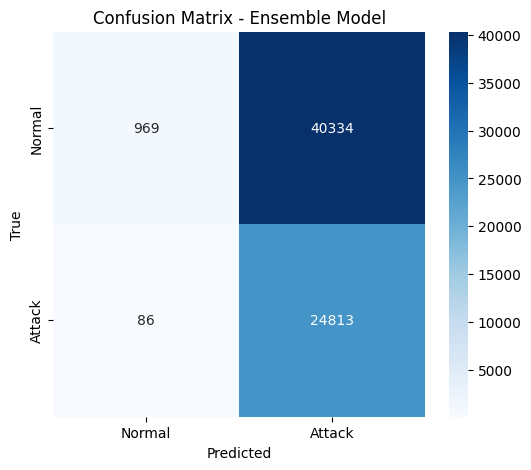

In [75]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()